<a href="https://colab.research.google.com/github/ratimayy/deep/blob/main/CNN1_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-ca749d57-8c65-e391-839b-14961a42cb78)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# 2. Create a non-sequential CNN with two alternative codes

In [ ]:
input1_dim = (224, 224, 1)     # 1-channel image
input2_dim = (224, 224, 3)     # 3-channel image

output_reg_dim = 4             # The number of output nodes for the regression head
output_cls_dim = 20            # The number of output nodes for the classification head

## 2.1 Use functional API only

In [ ]:
# Branch 1
img1ch = tf.keras.Input(shape=input1_dim, name='x1')    # 1-channel input image
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid')(img1ch)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
out_branch1ch = tf.keras.layers.Flatten()(x)

# Branch 2
img3ch = tf.keras.Input(shape=input2_dim, name='x2')    # 3-channel input image
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid')(img3ch)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
out_branch3ch = tf.keras.layers.Flatten()(x)

# Regression hactivation='softmaxead
x = tf.keras.layers.Dense(512,activation='relu')(out_branch1ch)
out_reg = tf.keras.layers.Dense( output_reg_dim, name='out_regress' )(x)

# Classification head
x = tf.keras.layers.Concatenate(axis=-1)( [out_branch1ch, out_branch3ch] )
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)       # drop rate = 50%
out_cls = tf.keras.layers.Dense(output_cls_dim, name='out_class' )(x)

# Construct the model
model1 = tf.keras.models.Model(inputs=[img1ch,img3ch], outputs=[out_reg, out_cls])

model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x1 (InputLayer)           │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2 (InputLayer)           │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 222, 222, 32)   │            320 │ x1[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ x2[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 111, 111, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 111, 111, 32)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │            128 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 111, 111, 32)   │            128 │ max_pooling2d_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 109, 109, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 54, 54, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 54, 54, 32)     │            128 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 32)     │            128 │ max_pooling2d_3[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 93312)          │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)  

 Total params: 238,923,032 (911.42 MB)

 Trainable params: 238,922,776 (911.42 MB)

 Non-trainable params: 256 (1.00 KB)

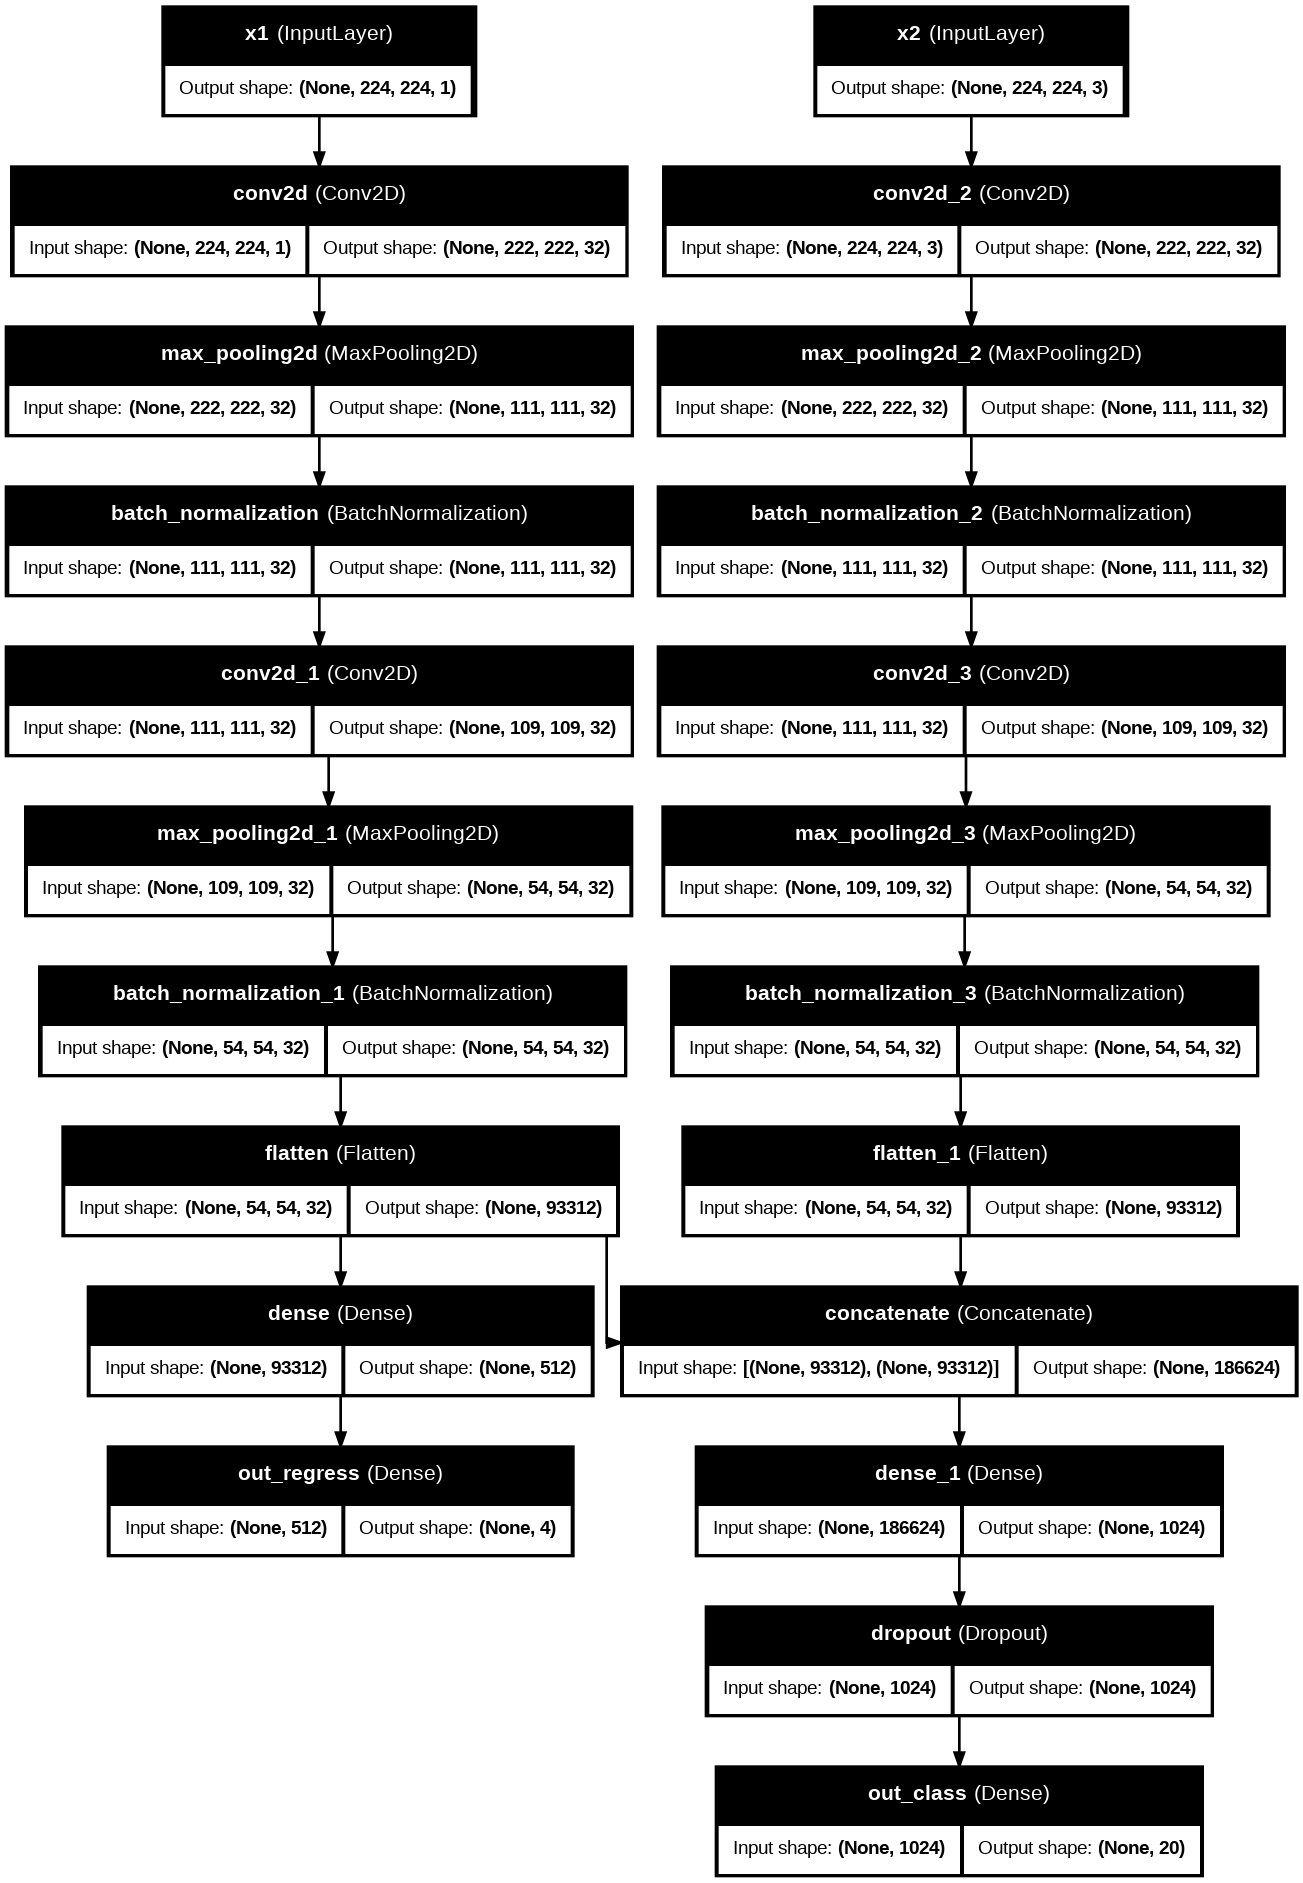

In [ ]:
tf.keras.utils.plot_model(model1, to_file='cnn1_nonsequential1.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

## 2.2 Use both sequential and functional APIs

The same model architecture as 2.1 but with a different coding style

In [ ]:
# Branch 1
branch1 = tf.keras.models.Sequential(name='branch1_model')    # 1-channel input image

branch1.add( tf.keras.Input(shape=input1_dim, name='x1') )
branch1.add( tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid') )
branch1.add( tf.keras.layers.MaxPool2D(pool_size=2) )
branch1.add( tf.keras.layers.BatchNormalization(axis=-1) )
branch1.add( tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid') )
branch1.add( tf.keras.layers.MaxPool2D(pool_size=2) )
branch1.add( tf.keras.layers.BatchNormalization(axis=-1) )
branch1.add( tf.keras.layers.Flatten() )

branch1.summary()

Model: "branch1_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 54, 54, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 93312)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,824 (38.38 KB)

 Trainable params: 9,696 (37.88 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Branch 2
branch2 = tf.keras.models.Sequential(name='branch2_model')    # 3-channel input image

branch2.add( tf.keras.Input(shape=input2_dim, name='x2') )
branch2.add( tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid') )
branch2.add( tf.keras.layers.MaxPool2D(pool_size=2) )
branch2.add( tf.keras.layers.BatchNormalization(axis=-1) )
branch2.add( tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='valid') )
branch2.add( tf.keras.layers.MaxPool2D(pool_size=2) )
branch2.add( tf.keras.layers.BatchNormalization(axis=-1) )
branch2.add( tf.keras.layers.Flatten() )

branch2.summary()

Model: "branch2_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 54, 54, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 93312)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,400 (40.62 KB)

 Trainable params: 10,272 (40.12 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Regression head
x = tf.keras.layers.Dense(512,activation='relu')( branch1.outputs[0] )
out_reg = tf.keras.layers.Dense( output_reg_dim, name='out_regress' )(x)

# Classification head
x = tf.keras.layers.Concatenate(axis=-1)( branch1.outputs + branch2.outputs )
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)       # drop rate = 50%
out_cls = tf.keras.layers.Dense(output_cls_dim, activation='softmax', name='out_class')(x)

# Construct the model
model2 = tf.keras.models.Model(inputs=branch1.inputs+branch2.inputs, outputs=[out_reg, out_cls])

model2.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x1 (InputLayer)           │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2 (InputLayer)           │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 222, 222, 32)   │            320 │ x1[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ x2[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 111, 111, 32)   │              0 │ conv2d_4[6][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 111, 111, 32)   │              0 │ conv2d_6[6][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 111, 111, 32)   │            128 │ max_pooling2d_4[5][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 111, 111, 32)   │            128 │ max_pooling2d_6[5][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 32)   │          9,248 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 32)   │          9,248 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 54, 54, 32)     │              0 │ conv2d_5[3][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 54, 54, 32)     │              0 │ conv2d_7[3][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 54, 54, 32)     │            128 │ max_pooling2d_5[2][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 54, 54, 32)     │            128 │ max_pooling2d_7[2][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 93312)          │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)  

 Total params: 238,923,032 (911.42 MB)

 Trainable params: 238,922,776 (911.42 MB)

 Non-trainable params: 256 (1.00 KB)

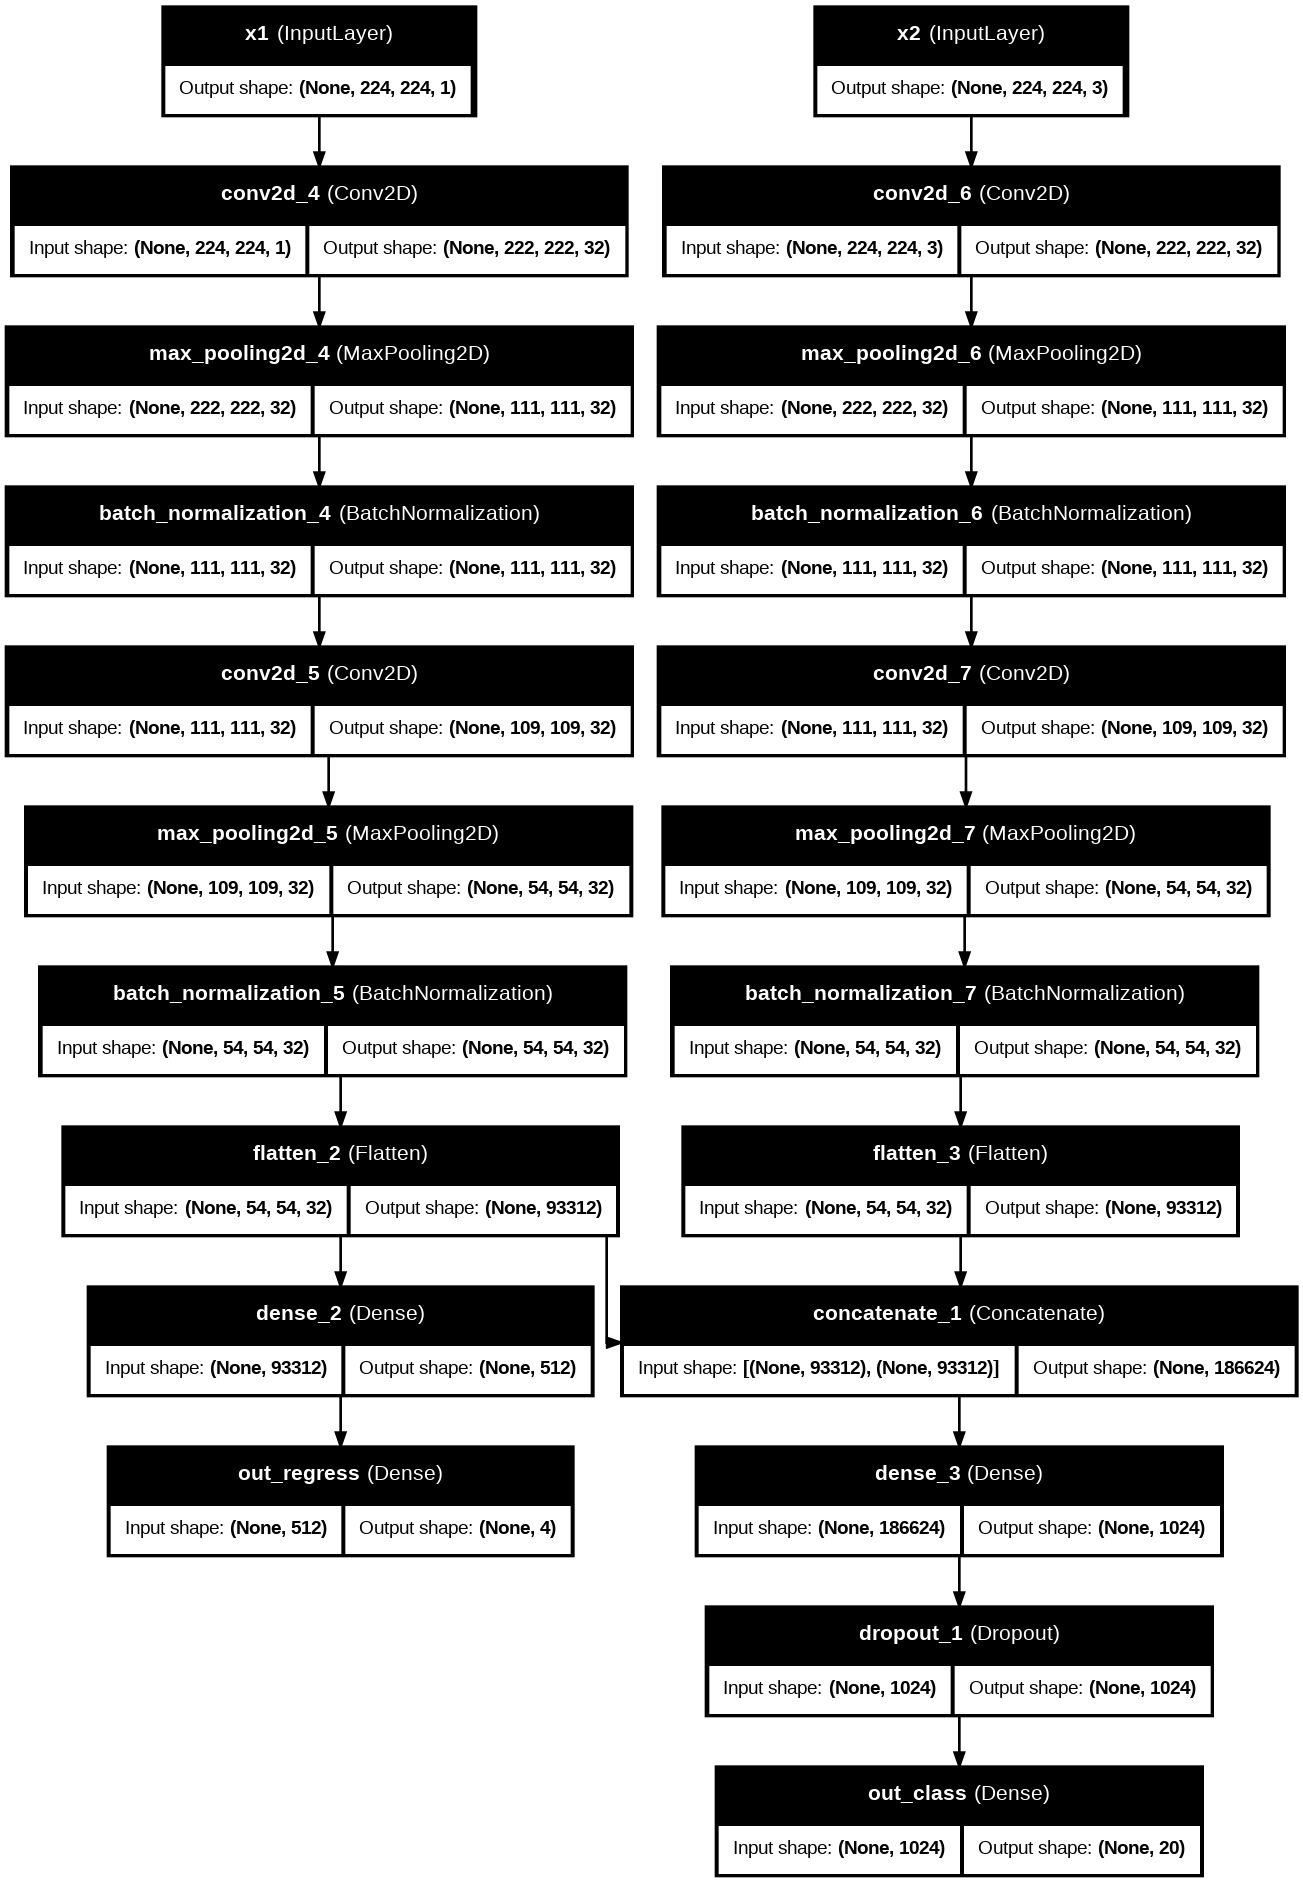

In [ ]:
tf.keras.utils.plot_model(model2, to_file='cnn1_nonsequential2.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

# 3. Test using the models (with random inputs)

In [ ]:
# Create one batch of random input data
batch_size = 7
x1 = np.random.rand( batch_size, *input1_dim ).astype(np.float32)
x2 = np.random.rand( batch_size, *input2_dim ).astype(np.float32)

print( f"x1.shape={x1.shape} , x1.dtype={x1.dtype} , min(x1)={np.min(x1):.4f} , max(x1)={np.max(x1):.4f}" )
print( f"x2.shape={x2.shape} , x2.dtype={x2.dtype} , min(x2)={np.min(x2):.4f} , max(x2)={np.max(x2):.4f}" )

x1.shape=(7, 224, 224, 1) , x1.dtype=float32 , min(x1)=0.0000 , max(x1)=1.0000
x2.shape=(7, 224, 224, 3) , x2.dtype=float32 , min(x2)=0.0000 , max(x2)=1.0000


In [ ]:
%%time

# Pass the data to 'model1'
y_pred_reg, y_pred_cls = model1.predict( [x1,x2] )

print( f"y_pred_reg.shape={y_pred_reg.shape} , y_pred_reg.dtype={y_pred_reg.dtype} , min(y_pred_reg)={np.min(y_pred_reg):.4f} , max(y_pred_reg)={np.max(y_pred_reg):.4f}" )
print( f"y_pred_cls.shape={y_pred_cls.shape} , y_pred_cls.dtype={y_pred_cls.dtype} , min(y_pred_cls)={np.min(y_pred_cls):.4f} , max(y_pred_cls)={np.max(y_pred_cls):.4f}" )

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
y_pred_reg.shape=(7, 4) , y_pred_reg.dtype=float32 , min(y_pred_reg)=-0.1146 , max(y_pred_reg)=0.0354
y_pred_cls.shape=(7, 20) , y_pred_cls.dtype=float32 , min(y_pred_cls)=-0.5470 , max(y_pred_cls)=0.8068
CPU times: user 8.11 s, sys: 400 ms, total: 8.51 s
Wall time: 3.86 s


In [ ]:
%%time
# Pass the data to 'model2'
y_pred_reg, y_pred_cls = model2.predict( [x1,x2] )

print( f"y_pred_reg.shape={y_pred_reg.shape} , y_pred_reg.dtype={y_pred_reg.dtype} , min(y_pred_reg)={np.min(y_pred_reg):.4f} , max(y_pred_reg)={np.max(y_pred_reg):.4f}" )
print( f"y_pred_cls.shape={y_pred_cls.shape} , y_pred_cls.dtype={y_pred_cls.dtype} , min(y_pred_cls)={np.min(y_pred_cls):.4f} , max(y_pred_cls)={np.max(y_pred_cls):.4f}" )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
y_pred_reg.shape=(7, 4) , y_pred_reg.dtype=float32 , min(y_pred_reg)=-0.3263 , max(y_pred_reg)=0.2227
y_pred_cls.shape=(7, 20) , y_pred_cls.dtype=float32 , min(y_pred_cls)=0.0368 , max(y_pred_cls)=0.0642
CPU times: user 701 ms, sys: 15.8 ms, total: 717 ms
Wall time: 860 ms
